### **Initialization**
* I use these 3 lines of code on top of each notebook because it won't cause any trouble while reloading or reworking on the Project. And the third line of code helps to make the visualization within the Notebook.

In [4]:
# Initialization with 3 lines of code
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading the Dependencies**
* I prefer to download all Libraries and Dependencies on one particular cell which mainly focus on Libraries and Dependencies.

In [5]:
# Downloading all necessary Libraries and Dependencies
# !pip install jupyterthemes 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, pickle
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from IPython.display import display
from jupyterthemes import jtplot
jtplot.style(theme = "monokai", context = "notebook", ticks = True, grid = False)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

**Getting the Data**
* I have manually downloaded the [Data](https://github.com/ThinamXx/TrafficSign..Classification/blob/master/TrafficSign%20Data.rar). I am using Google Colab for this Project, so the act of reading the [Data](https://github.com/ThinamXx/TrafficSign..Classification/blob/master/TrafficSign%20Data.rar) might be different in other platforms.
* The Data is saved in a pickle file. The Dataset is divided to 80% training and 20% testing. Training set is used for gradient calculations and weight updates. Validation set is used for cross validation which is performed to assess the training quality. Cross validation is used to overcome the over fitting which occurs when the algorithm focuses only on training details which looses generalization ability. Testing set is used for testing tained network. 
* The Dataset has 43 unique types of Traffic Sign images.

In [6]:
# Creating the Training set.
with open("/content/drive/My Drive/TrafficSign/train.p", mode="rb") as training_data:
  train = pickle.load(training_data)

# Creating the Validation set.
with open("/content/drive/My Drive/TrafficSign/valid.p", mode="rb") as validation_data:
  valid = pickle.load(validation_data)

# Creating the Testing set.
with open("/content/drive/My Drive/TrafficSign/test.p", mode="rb") as testing_data:
  test = pickle.load(testing_data)

* The dataset obtained above is in the form of Dictionary. So, The Data should be processed and prepared which assists in Training the algorithm.

In [7]:
# Inspecting the Dictionary
display(f"Training set: {train.keys()}");         # Training Dictionary
display(f"Validation set: {valid.keys()}");       # Validation Dictionary
display(f"Testing set: {test.keys()}")            # Testing Dictionary

"Training set: dict_keys(['coords', 'labels', 'features', 'sizes'])"

"Validation set: dict_keys(['coords', 'labels', 'features', 'sizes'])"

"Testing set: dict_keys(['sizes', 'coords', 'features', 'labels'])"

**Data Preparation**
* Preparing Training Data, Validation Data and Testing Data.

In [8]:
# Preparing the Training Data
X_train, y_train = train["features"], train["labels"]
display(X_train.shape, y_train.shape)

# Preparing the Validation Data
X_valid, y_valid = valid["features"], valid["labels"]
display(X_valid.shape, y_valid.shape)

# Preparing the Testing Data
X_test, y_test = test["features"], test["labels"]
display(X_test.shape, y_test.shape)

(34799, 32, 32, 3)

(34799,)

(4410, 32, 32, 3)

(4410,)

(12630, 32, 32, 3)

(12630,)

**Data Visualization**
* I want to check the Data present in the Training Dataset inorder to make confirmation that the Data exists and they are labelled properly.

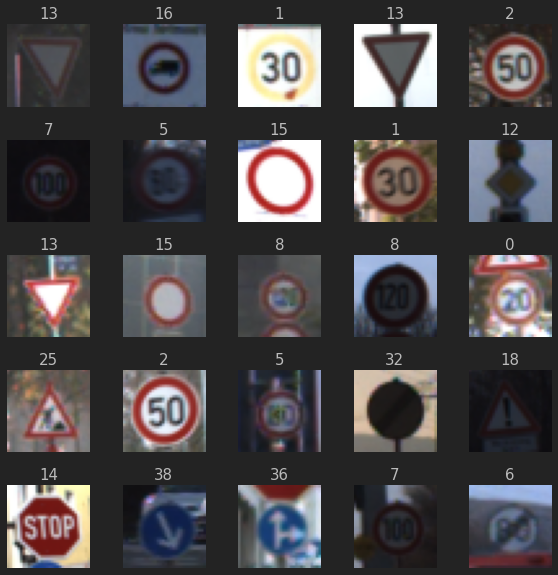

In [9]:
# Dimensions of the grid
length = 5
width = 5

# Visualizing the data
fig, axes = plt.subplots(length, width, figsize=(10, 10))   # Subplots returns the figure object and axes object.
axes = axes.ravel()                                         # Flatten the 5, 5 matrix.
n_train = len(X_train)                                      # Getting the length of training dataset.

for i in np.arange(0, length*width):                        # Creating the evenly space variables.
  index = np.random.randint(0, n_train)
  axes[i].imshow(X_train[index])
  axes[i].set_title(y_train[index], fontsize=15)
  axes[i].axis("off")

plt.subplots_adjust(hspace=0.4)                             # Adjusting the space between the plots

**Data Normalization**
* I will convert Images to Grayscale and I will perform Data Normalization inorder to reduce the data redundancy and enhance the data integrity.

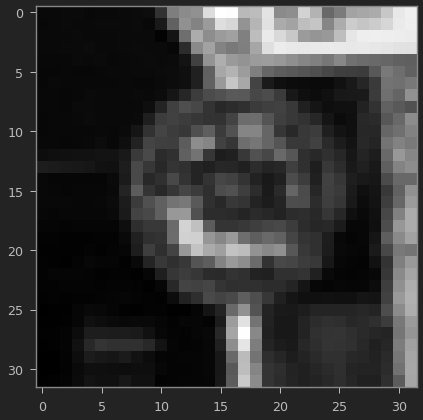

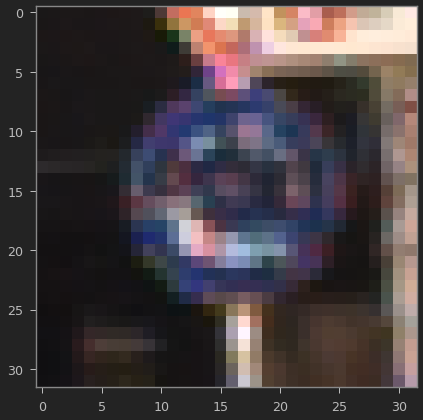

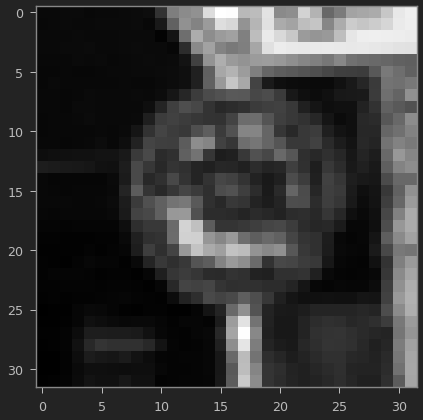

In [10]:
# Data Normalization and Data Preparation
X_train, y_train = shuffle(X_train, y_train)                                # Shuffling the Data

# Changing the RGB image to Grayscale image
X_train_g = np.sum(X_train / 3, axis=3, keepdims=True)
X_test_g = np.sum(X_test / 3, axis=3, keepdims=True)
X_valid_g = np.sum(X_valid / 3, axis=3, keepdims=True)

# Normalizing the Data.
X_train_ = (X_train_g - 255) / 255
X_test_ = (X_test_g - 255) / 255
X_valid_ = (X_valid_g - 255) / 255

# Visualizing the normalized image.
i = np.random.randint(1, len(X_train_g))                                    # Selecting random
plt.imshow(X_train_g[i].squeeze(), cmap="gray")                             # Visualizing the gray scale image
plt.figure()
plt.imshow(X_train[i])                                                      # Visualizing the actual RGB image
plt.figure()
plt.imshow(X_train_[i].squeeze(), cmap="gray")                              # Visualizing the normalized image

**Callbacks**
* It stops the further execution of the program when the certain accuracy is achieved. I will build the callbacks which will stop the execution of the program after 99% accuracy is achieved by the model.

In [11]:
# Building the callbacks model class.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > 0.99):
      print("\nReached 99% accurcy so stopping the execution of the program!")
      self.model.stop_training = True

# Instantiation of Callbacks.
callbacks = myCallback()

### **Convolutional Neural Network**
* Building Convolutional Neural Network from scratch using Tensorflow and Keras API.
* Since, it is a 43 class Classification problem i.e Multi class classification problem. I will use softmax activation for the final output.

In [12]:
# Building the Convolutional Neural Network.
model = tf.keras.models.Sequential([
                                    # The first convolution
                                    # Input image has 1 byte color
                                    tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(32, 32, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # The second convolution
                                    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # The third convolution
                                    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # Adding Dropout to the Neural Network
                                    tf.keras.layers.Dropout(0.2),
                                    # Flatten the Deep Neural Network
                                    tf.keras.layers.Flatten(),
                                    # First dense layer
                                    tf.keras.layers.Dense(512, activation="relu"),
                                    # Second dense layer
                                    tf.keras.layers.Dense(120, activation="relu"),
                                    # Third dense layer
                                    tf.keras.layers.Dense(84, activation="relu"),
                                    # Final layer of the Convolutional Neural Network
                                    tf.keras.layers.Dense(43, activation="softmax")                                   
])

# Inspecting the summary of the model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0

**Training the Model**
* I will compile the model with sparse categorical crossentropy since it is a multi class classification, and adam optimizer. Then, I will train the model and evalute the performance of the model in validation data.

In [13]:
# Compiling the Model
model.compile(loss="sparse_categorical_crossentropy",                      # Since, It is a multi class classification.
              optimizer="Adam",
              metrics=["accuracy"]
)

# Training the Model
history = model.fit(X_train_,                                              # Training Data.
                    y_train,                                               # Training Data.
                    epochs=55,                                             # Number of epochs.
                    verbose=1,                                             # Displaying the output of the model.
                    steps_per_epoch=8,
                    validation_data=(X_valid_, y_valid),                   # Evaluating the accuracy of the model.
                    validation_steps=8,
                    callbacks=[callbacks]
)

Epoch 1/55
8/8 [==============================] - 1s 122ms/step - loss: 3.6929 - accuracy: 0.0464 - val_loss: 3.6300 - val_accuracy: 0.0626
Epoch 2/55
8/8 [==============================] - 0s 52ms/step - loss: 3.5523 - accuracy: 0.0676 - val_loss: 3.5726 - val_accuracy: 0.0587
Epoch 3/55
8/8 [==============================] - 0s 50ms/step - loss: 3.4575 - accuracy: 0.0748 - val_loss: 3.5238 - val_accuracy: 0.0692
Epoch 4/55
8/8 [==============================] - 0s 50ms/step - loss: 3.3688 - accuracy: 0.0967 - val_loss: 3.4773 - val_accuracy: 0.0973
Epoch 5/55
8/8 [==============================] - 0s 51ms/step - loss: 3.2843 - accuracy: 0.1265 - val_loss: 3.3985 - val_accuracy: 0.1091
Epoch 6/55
8/8 [==============================] - 0s 49ms/step - loss: 3.1668 - accuracy: 0.1623 - val_loss: 3.2981 - val_accuracy: 0.1410
Epoch 7/55
8/8 [==============================] - 0s 48ms/step - loss: 3.0435 - accuracy: 0.1877 - val_loss: 3.1644 - val_accuracy: 0.1540
Epoch 8/55
8/8 [==========

**Model Evaluation**
* Plotting the Loss vs Accuracy.

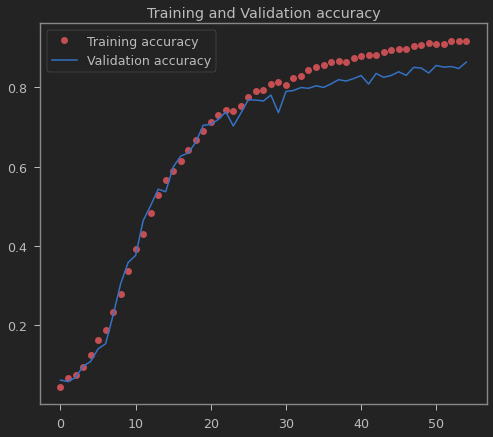

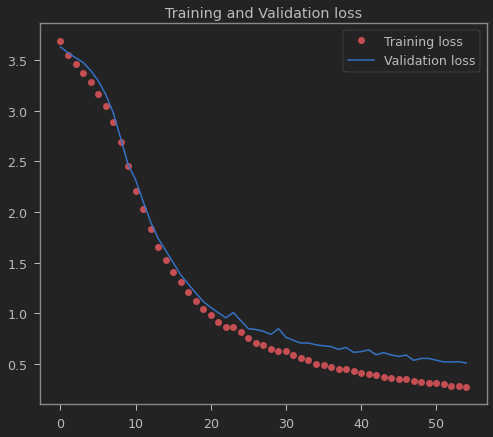

In [14]:
# Plotting the loss vs accuracy.
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

# Plotting the Training accuracy vs the Validation accuracy.
plt.plot(epochs, acc, "ro", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

# Plotting the Training loss vs the Validation loss.
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")

plt.legend()
plt.show()

**Model Prediction**
* Creating the Heatmap for Prediction.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


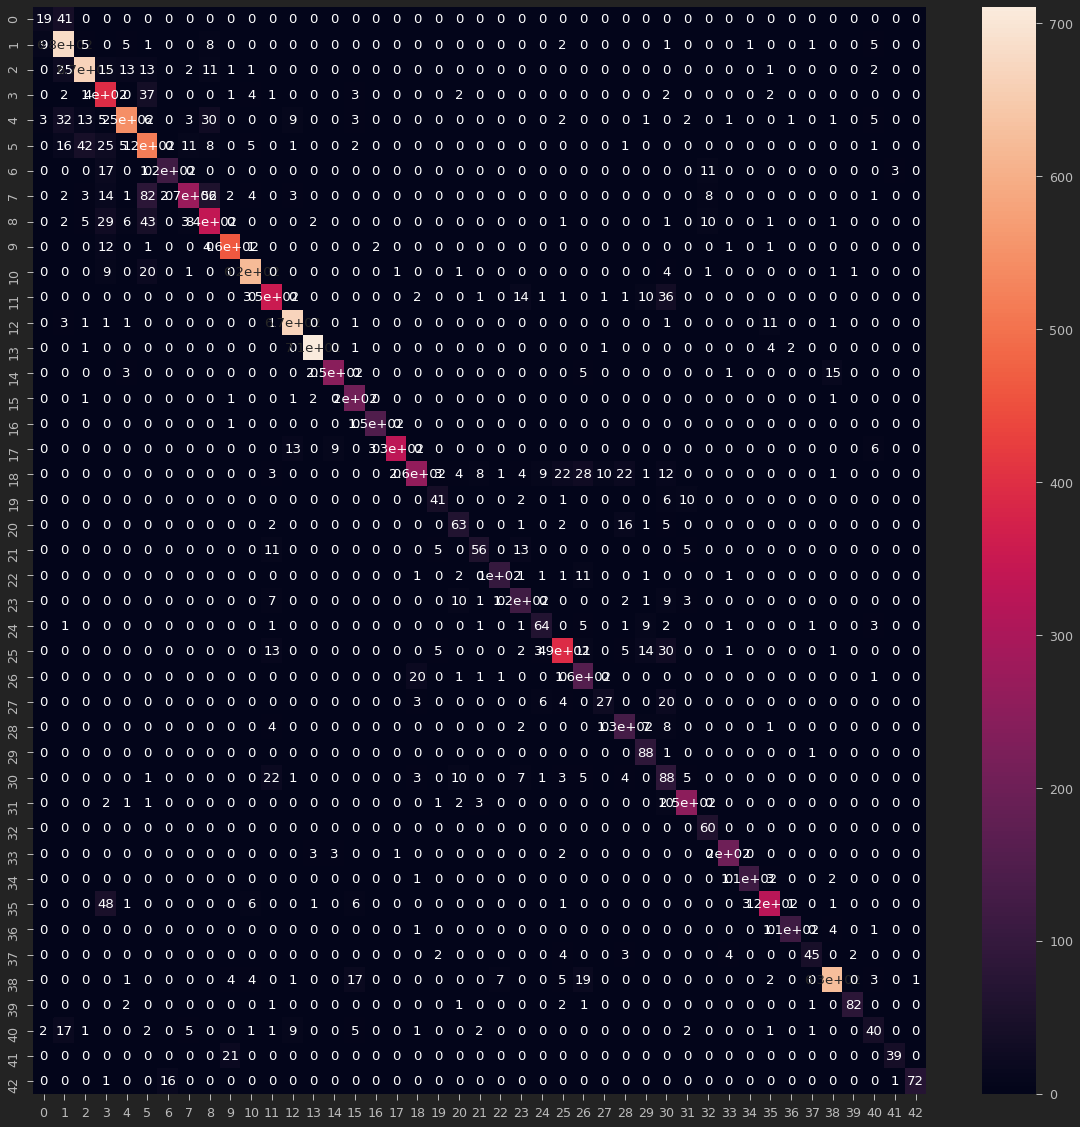

In [15]:
# Creating the heatmap.
predictions = model.predict_classes(X_test_) 

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True)

* Plotting the Predicted label vs the Actual label.

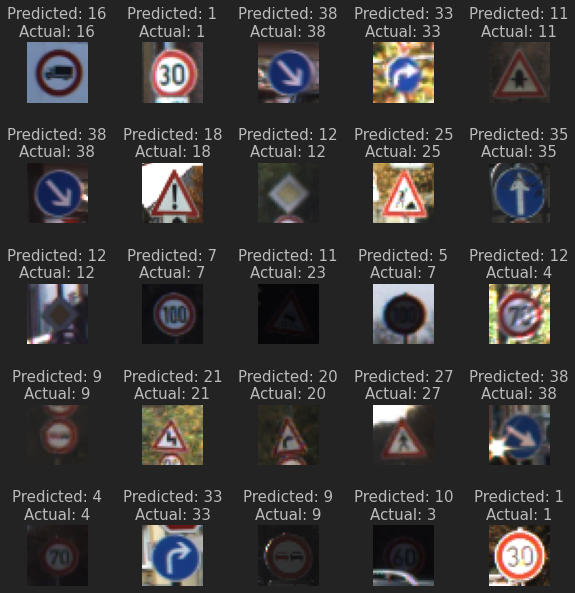

In [16]:
# Dimensions of the grid
length = 5
width = 5

# Visualizing the data
fig, axes = plt.subplots(length, width, figsize=(10, 10))   # Subplots returns the figure object and axes object.
axes = axes.ravel()                                         # Flatten the 5, 5 matrix.

for i in np.arange(0, length*width):                        # Creating the evenly space variables.
  axes[i].imshow(X_test[i])
  axes[i].set_title(f"Predicted: {predictions[i]}\nActual: {y_test[i]}", fontsize=15)
  axes[i].axis("off")

plt.subplots_adjust(hspace=1)                             # Adjusting the space between the plots

### **Appendix:**
* In this Project, I have created the Model which can classify the images of Traffic signs with 96% accuracy using Deep Convolutional Neural Network or CNN. The Dataset consist of 43 different classes of images. Each classes with its brief description or overview  are summarized below:
  - 0 = Speed Limit (20km/h)
  - 1 = Speed Limit (30km/h)
  - 2 = Speed Limit (50km/h)
  - 3 = Speed Limit (60km/h)
  - 4 = Speed Limit (70km/h)
  - 5 = Speed Limit (80km/h)
  - 6 = End of Speed Limit (80km/h)
  - 7 = Speed Limit (100km/h)
  - 8 = Speed Limit (120km/h)
  - 9 = No Passing
  - 10 = No Passing for the vehicles over 3.5 metric tons
  - 11 = Right of way at next intersection
  - 12 = Priority Road
  - 13 = Yield
  - 14 = Stop
  - 15 = No Vehicles
  - 16 = Vehicles over 3.5 metric tons prohibited
  - 17 = No Entry
  - 18 = General Caution 
  - 19 = Dangerous curve to the left
  - 20 = Dangerous curve to the right
  - 21 = Double Curve
  - 22 = Bumpy Road
  - 23 = Slippery Road
  - 24 = Road narrows on the right
  - 25 = Road Work
  - 26 = Traffic Signals
  - 27 = Pedestrains
  - 28 = Children Crossing
  - 29 = Bicycles Crossing
  - 30 = Beware of Ice/Snow
  - 31 = Wild animals crossing
  - 32 = End of all speed and Passing limits
  - 33 = Turn right ahead
  - 34 = Turn left ahead
  - 35 = Ahead only
  - 36 = Go straight or right
  - 37 = Go straight or left
  - 38 = Keep Right
  - 39 = Keep Left
  - 40 = Round about Mandatory
  - 41 = End of no Passing
  - 42 = End of no Passing by vehicles over 3.5 metric tons.